<h3> [MUCURI] Previsão de horas a frente </h3>

Importando o tensorflow, o keras e as bibliotecas que serão usadas

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from tabulate import tabulate as tb

%matplotlib inline

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Activation
from tensorflow.python.keras.optimizers import adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

import ai_utils.metrics as ai
import sklearn as sk

Lendo o dataset e tratando os valores nulos 

In [2]:
Mucuri = pd.read_csv('./train150_mucuri.txt', sep='\t', header = None)
Mucuri_prev = pd.read_csv('./prev150_mucuri.txt', sep='\t', header = None)
Mucuri.update(Mucuri[6].fillna(Mucuri[6].mean()))
Mucuri.describe()

,0,1,2,3,4,5,6,7,8
count,550.000000,550.000000,550.0,550.000000,550.000000,550.000000,550.000000,550.000000,550.000000
mean,12.087273,11.981818,2015.0,11.496364,8.176719,73.027647,24.443445,85.263578,1017.313986
std,6.891273,0.133730,0.0,6.940745,2.724988,64.996263,1.668117,8.579562,8.796185
min,1.000000,11.000000,2015.0,0.000000,1.211905,1.448179,20.616279,46.355556,937.534333
25%,6.000000,12.000000,2015.0,5.250000,6.215278,38.605367,23.315657,80.942222,1016.544542
50%,12.000000,12.000000,2015.0,11.000000,8.320000,59.019307,24.338280,86.765805,1020.046750
75%,18.000000,12.000000,2015.0,17.750000,10.146806,83.329498,25.359083,91.434531,1021.497917
max,30.000000,12.000000,2015.0,23.000000,13.572222,356.553715,30.140625,98.000000,1023.726500


Transformando o dataset em um numpy array e separando a coluna da velocidade do vento

In [3]:
x_array = Mucuri.values 
y_array = list(Mucuri[4].values)

Criando o modelo da rede

In [4]:
def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(9, activation='relu', input_shape=(9,)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),
  ])

  model.compile(optimizer='adam',
                loss='mse',
                metrics=['mae'])
  return model

Treinando a rede em 6 épocas

In [5]:
model = get_compiled_model()
history = model.fit(x_array, y_array, epochs=6, validation_split=0.2)

W0916 13:54:00.339208 13428 deprecation.py:506] From D:\Anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 440 samples, validate on 110 samples
Epoch 1/6
440/440 [==============================] - 0s 471us/sample - loss: 57191.8622 - mean_absolute_error: 232.9603 - val_loss: 19307.3645 - val_mean_absolute_error: 138.8909
Epoch 2/6
440/440 [==============================] - 0s 70us/sample - loss: 9699.2544 - mean_absolute_error: 93.1711 - val_loss: 940.4460 - val_mean_absolute_error: 30.3727
Epoch 3/6
440/440 [==============================] - 0s 73us/sample - loss: 333.6149 - mean_absolute_error: 14.3643 - val_loss: 465.0008 - val_mean_absolute_error: 21.1540
Epoch 4/6
440/440 [==============================] - 0s 69us/sample - loss: 364.3624 - mean_absolute_error: 18.4868 - val_loss: 559.2260 - val_mean_absolute_error: 23.2366
Epoch 5/6
440/440 [==============================] - 0s 63us/sample - loss: 160.0824 - mean_absolute_error: 11.3948 - val_loss: 126.8438 - val_mean_absolute_error: 10.3481
Epoch 6/6
440/440 [==============================] - 0s 66us/sample - loss: 25.7016 - 

Gráfico de evolução do loss de treinamento e validação ao longo das épocas 

[57191.86218039773, 9699.254383433949, 333.614858453924, 364.3623707164418, 160.08242048783737, 25.701550951871006]


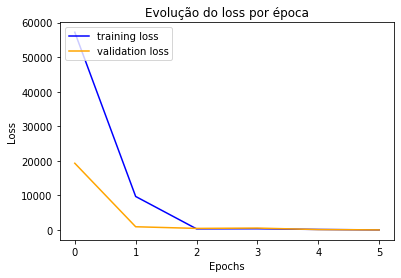

In [6]:
print(history.history['loss'])
plt.plot(history.history['loss'], color = 'blue', label='training loss')
plt.plot(history.history['val_loss'], color = 'orange', label='validation loss') 
plt.legend(loc='upper left')
plt.title('Evolução do loss por época')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [7]:
lossEvaluate, acc = model.evaluate(x_array, y_array)

550/550 [==============================] - 0s 29us/sample - loss: 28.4996 - mean_absolute_error: 4.2366


Manipulando o dataset para previsão

In [8]:
p1_array = x_array[1:550, 0:4]
p2_array = x_array[0:549, 5:]
w_array = model.predict(x_array)
w_array = w_array[0:549, :]

new_array = np.hstack((p1_array, w_array, p2_array))

Previsão e comparação gráfica entre o previsto e o observado para o dataset de treinamento

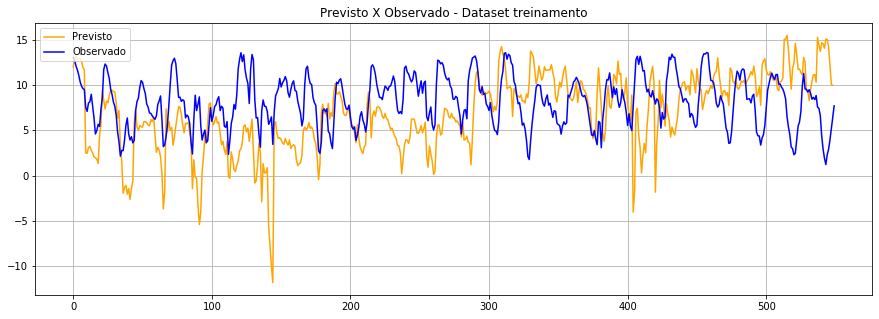

In [9]:
vel = model.predict(new_array)

plt.figure(figsize=(15,5))
plt.grid(True)
plt.plot(vel, color='orange', label='Previsto')
plt.plot(y_array, color='blue', label='Observado') 
plt.legend(loc='upper left')
plt.title('Previsto X Observado - Dataset treinamento')
plt.show()

Métricas para avaliação: R, R2, Fac2, MSE e MAE para o dataset de treinamento

In [10]:
mae = sk.metrics.mean_absolute_error(w_array, vel)
mse = sk.metrics.mean_squared_error(w_array, vel)
R2 = sk.metrics.r2_score(w_array, vel)

predconvert = tf.convert_to_tensor(vel)
realconvert = tf.convert_to_tensor(w_array)
R = ai.pearson_r(realconvert, predconvert, to_numpy=True)
Fac2 = ai.fac2(realconvert, predconvert, to_numpy=True)

print(tb([['MAE: ', mae], ['MSE: ', mse], ['R2: ', R2], ['R: ', R], ['Fac2: ', Fac2]], headers=['Métrica', 'Valor']))

Métrica       Valor
---------  --------
MAE:       0.48209
MSE:       0.610631
R2:        0.970068
R:         0.988281
Fac2:      0.961749


Manipulando os dados do dataset de teste

In [11]:
Mucuri_prev = pd.read_csv('./prev150_mucuri.txt', sep='\t', header = None)
Mucuri_prev.update(Mucuri_prev[6].fillna(Mucuri_prev[6].mean()))
Mucuri_prev.describe()
xPrev_array = Mucuri_prev.values 
yPrev_array = list(Mucuri_prev[4].values)

In [12]:
pred = []
for x in range(6):
    if (x == 0):
        p1Prev_array = xPrev_array[1:194, 0:4]
        p2Prev_array = xPrev_array[0:193, 5:]
        wPrev_array = model.predict(xPrev_array) 
        wPrev_array = wPrev_array[0:193, :]
        pred.append(wPrev_array)
        Prev_array = np.hstack((p1Prev_array, wPrev_array, p2Prev_array))
    else: 
        wPrev_array = model.predict(Prev_array) 
        Prev_array = np.hstack((p1Prev_array, wPrev_array, p2Prev_array))
        pred.append(wPrev_array)

Previsão e comparação gráfica entre o previsto e o observado para o dataset de teste

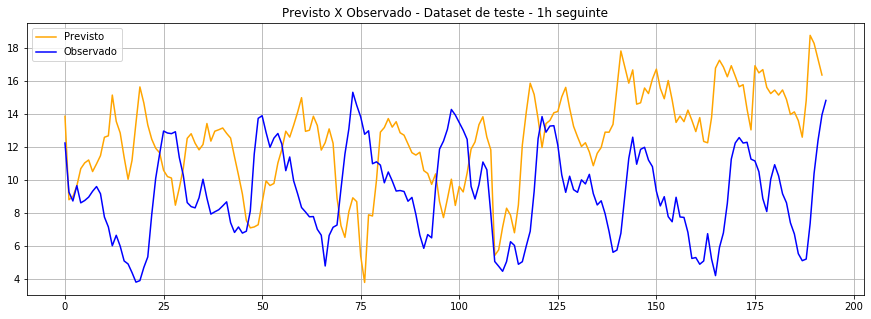

In [13]:
plt.figure(figsize=(15,5))
plt.grid(True)
plt.plot(pred[0], color='orange', label='Previsto')
plt.plot(yPrev_array, color='blue', label='Observado') 
plt.legend(loc='upper left')
plt.title('Previsto X Observado - Dataset de teste - 1h seguinte')
plt.show()

mae1h = sk.metrics.mean_absolute_error(wPrev_array, pred[0])
mse1h = sk.metrics.mean_squared_error(wPrev_array, pred[0])
R21h = sk.metrics.r2_score(wPrev_array, pred[0])

predconvert = tf.convert_to_tensor(pred[0])
realconvert = tf.convert_to_tensor(wPrev_array)
R1h = ai.pearson_r(realconvert, predconvert, to_numpy=True)
Fac21h = ai.fac2(realconvert, predconvert, to_numpy=True)

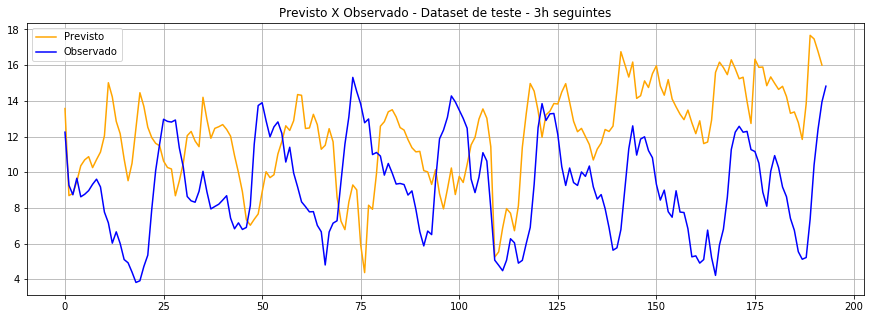

In [14]:
plt.figure(figsize=(15,5))
plt.grid(True)
plt.plot(pred[2], color='orange', label='Previsto')
plt.plot(yPrev_array, color='blue', label='Observado') 
plt.legend(loc='upper left')
plt.title('Previsto X Observado - Dataset de teste - 3h seguintes')
plt.show()

mae3h = sk.metrics.mean_absolute_error(wPrev_array, pred[2])
mse3h = sk.metrics.mean_squared_error(wPrev_array, pred[2])
R23h = sk.metrics.r2_score(wPrev_array, pred[2])

predconvert = tf.convert_to_tensor(pred[2])
realconvert = tf.convert_to_tensor(wPrev_array)
R3h = ai.pearson_r(realconvert, predconvert, to_numpy=True)
Fac23h = ai.fac2(realconvert, predconvert, to_numpy=True)

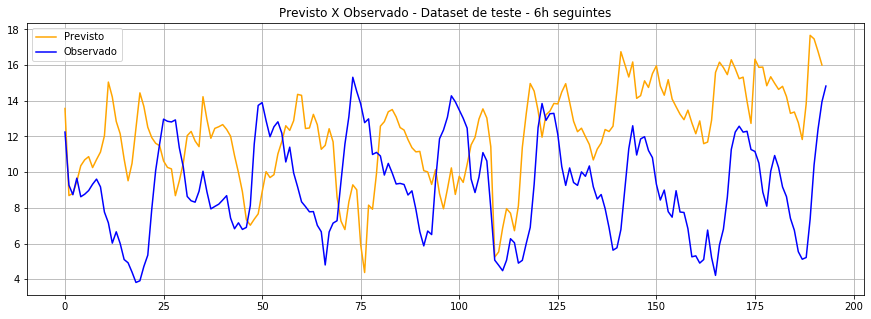

In [15]:
plt.figure(figsize=(15,5))
plt.grid(True)
plt.plot(pred[5], color='orange', label='Previsto')
plt.plot(yPrev_array, color='blue', label='Observado') 
plt.legend(loc='upper left')
plt.title('Previsto X Observado - Dataset de teste - 6h seguintes')
plt.show()

mae6h = sk.metrics.mean_absolute_error(wPrev_array, pred[5])
mse6h = sk.metrics.mean_squared_error(wPrev_array, pred[5])
R26h = sk.metrics.r2_score(wPrev_array, pred[5])

predconvert = tf.convert_to_tensor(pred[5])
realconvert = tf.convert_to_tensor(wPrev_array)
R6h = ai.pearson_r(realconvert, predconvert, to_numpy=True)
Fac26h = ai.fac2(realconvert, predconvert, to_numpy=True)

Comparação das métricas para cada horizonte de previsão

In [16]:
print(tb([['MAE: ', mae1h, mae3h, mae6h], ['MSE: ', mse1h, mse3h, mse6h], ['R2: ', R21h, R23h, R26h], ['R: ', R1h, R3h, R6h], ['Fac2: ', Fac21h, Fac23h, Fac26h]], headers=['Métrica', '1h', '3h', '6h']))

Métrica          1h           3h    6h
---------  --------  -----------  ----
MAE:       0.476523  0.00515502      0
MSE:       0.328151  4.21988e-05     0
R2:        0.951273  0.999994        1
R:         0.990007  0.999998        1
Fac2:      1         1               1
